In [1]:
import sys
import pprint
import pylab as pl
import inspect
import os

root_path =  os.path.abspath(os.path.join(os.path.pardir))
sys.path.insert(0, root_path)

import pymola.parser
import pymola.gen_sympy
import sympy
import sympy.physics.mechanics as mech

sympy.init_printing()
mech.mechanics_printing()

%load_ext autoreload

%autoreload 2
%matplotlib inline

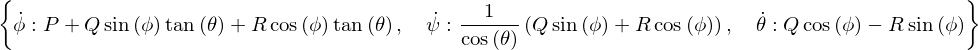

In [2]:
frame_i = mech.ReferenceFrame('i')
t = sympy.symbols('t')
phi, theta, psi, P, Q, R, x, y, z, U, V, W = mech.dynamicsymbols(
    'phi, theta, psi, P, Q, R, x, y, z, U, V, W')
frame_b = frame_i.orientnew('b', 'Body', (psi, theta, phi), '321')
omega_ib = P*frame_b.x + Q*frame_b.y + R*frame_b.z
euler_sol = sympy.solve((frame_b.ang_vel_in(frame_i) - omega_ib).to_matrix(frame_b),
            [v.diff(t) for v in [phi, theta, psi]])
frame_b.set_ang_vel(frame_i, omega_ib)
euler_sol

In [3]:
point_o = mech.Point('o')
point_cm = point_o.locatenew('cm', x*frame_i.x + y*frame_i.y + z*frame_i.z)
point_cm.set_vel(frame_b, 0)
M_x, M_y, M_z, F_x, F_y, F_z = mech.dynamicsymbols('M_x, M_y, M_z, F_x, F_y, F_z')
M_b = M_x*frame_b.x + M_y*frame_b.y + M_z*frame_b.z
F_b = F_x*frame_b.x + F_y*frame_b.y + F_z*frame_b.z
V_i = U*frame_b.x + V*frame_b.y + W*frame_b.z
point_cm.set_vel(frame_i, V_i)
J_x, J_y, J_z, m = sympy.symbols('J_x, J_y, J_z, m')
aircraft = mech.RigidBody('aircraft', point_cm,
                          frame_b, m,
                          (mech.inertia(frame_b, J_x, J_y, J_z), point_cm))

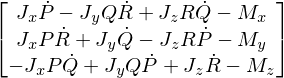

In [4]:
H_i = aircraft.angular_momentum(point_cm, frame_i)
i_H_i = H_i.diff(t, frame_b) + frame_b.ang_acc_in(frame_i).cross(H_i)
(i_H_i - M_b).to_matrix(frame_b)

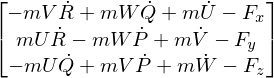

In [5]:
L_i = aircraft.linear_momentum(frame_i)
i_L_i = L_i.diff(t, frame_b) + frame_b.ang_acc_in(frame_i).cross(L_i)
(i_L_i - F_b).to_matrix(frame_b)

In [12]:
ast = pymola.parser.parse('''
model Quad
    Real F_x, F_y, F_z;
    Real M_x, M_y, M_z;
    Real phi, theta, psi;
    Real P, Q, R;
    Real x, y, z;
    Real U, V, W;
    parameter Real J_x=1, J_y=1, J_z=1, m=1;
equation
    M_x = -P - phi;
    M_y = -Q - theta;
    M_z = -R - psi;
    F_x = -x;
    F_y = -y;
    F_z = -z;
    der(x) = U;
    der(y) = V;
    der(z) = W;
    -m*V*der(R) + m*W*der(Q) + m*der(U) = F_x;
    m*U*der(R) - m*W*der(P) + m*der(V) = F_y;
    -m*U*der(Q) + m*V*der(P) + m*der(W) = F_z;
    der(phi) = P + Q*sin(phi)*tan(theta) + R*cos(phi)*tan(theta);
    der(theta) = Q*cos(phi) - R*sin(phi);
    cos(theta)*der(psi) = Q*sin(phi) + R*cos(phi);
    der(P) = M_x;
    der(Q) = M_y;
    der(R) = M_z;
end Quad;
''')
#print(ast)

In [13]:
quad_src = pymola.gen_sympy.generate(ast, 'Quad')
#exec(quad_src)
#print(quad_src)

TypeError: unsupported format string passed to ComponentRef.__format__

In [14]:
exec(quad_src)
quad = Quad()

NameError: name 'quad_src' is not defined

In [9]:
res = quad.simulate(x0 = [0,0,0, 1,2,3, 0, 0, 0, 1, 0, 0])

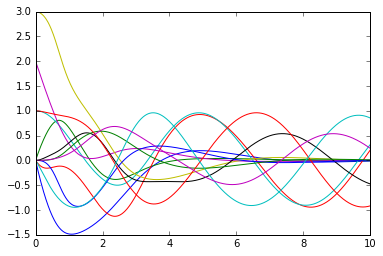

In [10]:
pl.plot(res['t'], res['x']);

In [11]:
v_x, v_y, v_z, x, y, z = sympy.physics.mechanics.dynamicsymbols('v_x, v_y, v_z, x, y, z')
m, g = sympy.symbols('m, g')
V = aircraft.kinetic_energy(frame_i) + m*g*z
V

In [12]:
sympy.Matrix([V]).jacobian(quad.x).dot(quad.f).expand().simplify()